# CS Capstone Project — Main Project Pipeline - Vehicle 12V Battery State of Health (SoH)

**Author:** Jason Waterman  
**Course:** UC Berkeley AI/ML Professional Certificate  
**Created:** 2025-10-21  
**Last Updated:** 2025-10-29  
**Version:** 1.0.0  

---

## 📖 Description
This notebook is the main project driver notebook behind my UC Berkeley AI/ML program capstone project. It  walks through each of the project phases from problem statement, data collection, visual overview, data cleaning and pre-processing, feature engineering, model pipeline development (LR, Lasso, Ridge, Random Forest Ensemble, LSTM), results analysis, and next steps. 

Not every file in this project repository is executable as is. This notebook serves as guide to each step I took in defining the problem and unpacking the steps to reveal end results and conclusion. I used the Python kernal 3.12.2 for most of the project coding with the exception of Python (tf-metal) 3.10.18 for execution of the LSTM models which required GPU processing. 

### 🔑 Objective
To develop scalable AI models that infer vehicle health directly from already available in-vehicle network data. 

### 💡 Insights
- Initial results demonstrate that analysis of the vehicle network data reveals there are reliable predictors of overall vehicle health - including load and wake-state releated signals - revealing a scalable path to predictive vehicle intelligence. 
- Even simple ML models, using just IBS signals, can start capturing dynamics that vendor SOH misses.
- By incorporating more signals and modern ML (LSTMs), we can capture real-time state of health more accurately and robustly. 
- Looking at how we may actualy deploy this in a vehicle, we could use the simpler ML models using just the IBS signals embedded in a vehicle ECU give "real-time" predictive behavior. To further extend the fleet wide analytics the more powerful LSTM model could be deployed to the cloud to give on-going insights to vehicle behavior. This would represet a good starting point for further exploration. 

## Problem Statement
EVs (and really all modern vehicles) are data-rich but insight poor. The 12V battery remains the leading roadside failure cause despite vehicles broadcasting thousands of network signals (CAN/LIN/Ethernet) that already reflect system health. This is due to the fact that the 12V battery serves as the primary power source for the vehicle's ECUs. If the 12V has a problem then the vehicle will have a problem. Therefore, it is very important to constantly monitor the 12V health and re-charge it from the HV battery, when necessary.  

For this project, I have gathered data directly from a current production vehicle - 2024 Fisker Ocean - to attempt to analyze these network signals for the 12V battery state of health indicators. My primary network signal target is the Intelligent Battery Sensor (IBS). The IBS main purpose is to monitor the 12V battery SoH and, in fact, has a SoH signal which indicates in precentage terms the battery's SoH (IBS_StateOfHealth). In addition, I calculate a real-time SoH using the other IBS signals including voltage, current, resistance & temperature. This is referred to as Calculated SOH1.
I use both IBS SoH and calculated SOH1 as targets to train my ML models.   

I start out by using only IBS signals for feature modeling of SOH/SOH1 using simpler ML models - Linear Regression (LR), Ridge, Lasso, and Decision Tree (DT). Later I use derived 12V battery charging cycle metrics to expand my traning features. I then perform some feature engineering using the Random Forest (RF) Essemble modeling on the expanded feature set which includes these charging cycle metrics. Finally, I examine all the network signals using the more powerful LSTM (Long Short Term Memory) modeling which requires the higher processing capabilities of a GPU. 

My project workflow as outlined in this notebook is as follows:
1. Data collection process
2. Data converstion from timestamped Vector .blf binary to usable .csv
3. Visual overview of IBS data logs
4. Cleaning & preparation of data for usage in training models
5. Calculated SOH1 vs IBS SOH
6. Linear Regression cross validation + Ridge + Lasso
7. Expand beyond IBS signals to include charge cycle metrics
8. Feature Engineering - Decision Tree & Random Forest 
9. LSTM approach & data preprocessing
10. LSTM training on all network signals
11. Deployment and other next steps


## 1. Data collection process
The vehicle network data collection on the 2024 Fisker Ocean was done using a Vector CANalyzer tool connected to the vehicle's OBD2 port. A series of data logs were collected over a 3 month period (Jun-Aug 2025). These data logs were gathered to primarily capture the IBS signals including IBS SoH which essentially serves as the OEM "ground-truth" for the 12V battery health. The IBS signals show the constant charging cycling of the 12V battery as it is recharged from the HV battery. Most of the vehicle's 50+ ECUs rely on the 12V battery to operate. 

The data logs collected in the Vector binary file .blf format. These must be converted to a timestamped .csv format for my project workflow analysis. All the .blf data logs are not provided but the converted .csv files used by the project is located in the /can_data/*.csv folder. 

## 2. Data converstion from timestamped Vector .blf binary to usable .csv
This process proved to be more challenging than expected. Without having the Vector toolchain available to me, I had to find blf to csv converter that produced a workable file that I could analyze. I started out using a user created Python library called canda. However, the library was created a few years ago and I found it not very compatable with the current Python version I was using (3.12.2). Therefore, I ended up using an auto-coded BLFReader + cantools DBC decode python script to perform the necessary conversion. 

Each data log file had to be individually converted. The results are stored in the /can_data/*.csv project folder. I have provided the Python converter script cs_convert_blf2csv.py in the /src project folder. Usage of this script is shown below. However, since I do not provide the .blf or .dbc files used for the project here, the code is not executable but only serves as an example for how to use it. 

In [ ]:
python cs_convert_blf2csv.py \
  --blf "/can_data/12V IBS Full load 2025-08-20_22-17-18_L006.blf" \
  --dbc "/can_data/FM29_EVBUS_Matrix_CANFD_V390.6_20230411.dbc" \
  --dbc "/can_data/FM29_BodyBUS_Matrix_CAN_V390.6_20230411.dbc" \
  --outdir "/can_data"

## 3. Visual overview of IBS data logs
The first step to any ML problem is to get a visual representation of the dataset that you are using. To do this I created an auto-coded python script called cs_gen_log-report.py. The script takes a .blf log file as an input and creates a html log file report output stored in \outputs\reports\*.html. The script is located in the /src project folder. I do not provide the executable code here because it requires a raw binary .blf file which are not included with this project. However, I have stored all the data log file reports in the output folder /outputs/reports/*.html. 

An example data log report can be viewed by running the code below. You can see a report for any of the other data log by changing the filename. 

The report gives some basic info on the data log (log name, log date, blf file analyzed) then proceeds by giving a technician summary, charging cycle KPIs, signal correlation analysis, and finally plots of the charging cycles including 12V battery voltage, current, state of charge (SoC), and state of health (SoH) as reported by the IBS sensor. 

In [14]:
from pathlib import Path
import webbrowser

# Open an example data log report from my  project folder structure 
p = Path("outputs/reports/12V Management  Discharge and Charge Cycle 2025-06-29_08-10-35_log-report.html")

# Resolve the data path
file_path = p.resolve()

# Open report in default browser 
webbrowser.open(file_path.as_uri())


True

## 4. Cleaning & preparation of data for usage in training models
Now comes the point where we can start to clean and prepare the time series log data for analysis. To do this I have created a python notebook called cs_clean_xxxx.ipynb that cleans individual data log .csv files. The notebook takes any data log csv contained in the /can_data project folder and cleans the file step by step. The notebook creates an cleaned output file and stores it into the /can_data/cleaned project folder with project filename appended with "_IBS_only_cleaned." To clean a specific file you will need to change the filename in the notebook. 

To clean a specific file click on this link <a href="cs_clean_0003.ipynb" target="_blank">cs_clean_0003.ipynb</a> to open the notebook file or run the code in the cell below. Then change the filename to whatever file from the /can_data/*.csv project folder. 

In [31]:
import webbrowser
webbrowser.open(Path("cs_clean_0003.ipynb").resolve().as_uri())

True

## 5. Calculated SOH1 vs IBS SOH
Now that the primary features are selected for model training, let's take a deeper dive into the target data to use for the supervised learning - IBS SOH and calculated SOH1. Let's compare IBS SOH (the sensor-reported state of health from the vehicle's intelligent battery sensor) vs. the calculated SOH1 (the derived metric created from voltage, current, temperature and resistance signals).

#### IBS SOH
Pros
- Represents the OEM "ground truth" for the 12V battery health
- It's a native signal measured and reported directly from the IBS sensor
- Enables model benchmarking: if our ML model can reproduce or predict IBS SOH, it validates that the model understands the same physics as the OEM IBS
- Normalized 0-100%. Easy for regression models to interpret.
- Less noisy since it's filtered by the OEM IBS
- Decision Tree and Random Forest models can reveal which features most influence the IBS SOH
Cons
- Not physically accurate for true battery health. Gradually adapts over a prolonged time period.
- Limited dynomic range: it can remain flat for long periods and not reflect the real-time physics of battery health
- Device and firmware specific. May vary across vehicle platforms.

#### Calculated SOH1
Pros
- Derived from a SOH1 algorithm which takes into account the physics of battery health - voltage and current under load, internal resistance, charging cycle metrics
- More predictive of real-time battery health
- Customizable. We can tune the algorithm to emphasize different degredation dynamics (thermal stress, cycling, parasitic drain)
- Makes it a great research-grade target for ML explainability
- Since it is computed continuously and reflects subtle time-dependent degredation trends, it provides richer signal dynamics of Recurrent Neural Networks (RNNs) such as LSTMs
- OEM agnostic. Portable across vehciles
Cons
- Highly dependent on algorithm quality. If algorithm introduces noise, bias, or poor temperature compensation, models with learn those artifacts
- Harder to validate against the IBS SOH "ground truth"
- Decision Tree/Random Forest interpretability might be trickier since SOH1 may evolve continuously rather than stepwise
- Some of the same signals used to compute SOH1 may also be part of the training feature set - risk of data leakage

#### Approach for capstone project
- Use IBS SOH as target for LR, Lasso, Ridge, and Decision Tree cross validation modeling to identify signals that correlate health diagnostics
- Use calculated SOH1 for predictive modeling. Train LSTM using calculated SOH1 to capture real-time dynamics of battery health
- Cross validation and comparison. Compare IBS SOH with calculated SOH1 to show model's added diagnostic insight or ealier degredation detection

#### Calculated SOH1 Algorithm
The SoH₁ algorithm estimates 12-V battery health from time-series data derived primarily from the Intelligent Battery Sensor (IBS) and related vehicle network signals.
Unlike static voltage checks, SoH₁ leverages dynamic behavioral features—how the battery responds to real operating conditions—to infer degradation trends.

SOH1 = f(V, I, T, Rint​, Qcap​)
where
- V = battery terminal voltage
- I = charge / discharge current
- T = temperature 
- Rint = effective internal resistance (from load or recovery slopes)
- Qcap = available capacity estimate (integrated over charge/discharge cycles)
The calculated SOH1 is normalized between 0-1, representing the ratio of current effective capacity/resistance performance relative to a healthy baseline

The SOH1 algorithm was auto-coded based upon the above model calculation. It is coded in the calculate_soh1 function located in the /src/soh_utils.py project file. The function can return a single median SOH1 calculated over a data log file or can return a timeseries SOH1 calculated at a 1s basis. Both are used throughout the project when a model needs to be trained on a calculated SOH1 target.

To observe the dynamics of IBS SOH and calculated SOH1 over all the data logs collected I have created a notebook that generates a complete manifest for the project. This notebook is available in the project directory /cs_create_ibs_soh_manifest.ipynb and accessed by clicking on the link <a href="cs_create_ibs_soh_manifest.ipynb" target="_blank">cs_create_ibs_soh_manifest.ipynb</a> to open the notebook file or run the code in the cell below. 


In [ ]:
# Open create ibs soh manifest notebook in new tab
import webbrowser
webbrowser.open(Path("cs_create_ibs_soh_manifest.ipynb").resolve().as_uri())

True

#### IBS SOH Manifest
The IBS SOH Manifest created by this notebook is located in the project folder outputs/logs/manifest.csv. The manifest may be viewed by running the code below. The manifest is an overview of all the data logs and IBS signals gathered over the 3 month project period (Jun-Aug 2025). It contains one entry per data log and includes the following parameters:
- time: date & time stamp for the vehicle data log
- log_id: filename of data log
- soh: median IBS SOH (over data log)
- soh1: median calculated SOH1 (over data log)
- soh_c: median calculated battery capactity (over data log)
- soh_r: median calculated internal battery resistance (over data log)
- cycles: # of charge/discharge cycles 
- path: file path to the cleaned data log file

In [ ]:
import pandas as pd
from pathlib import Path

# Read in manifest data file 
OUTPUT_MANIFEST_CSV = Path("outputs/logs/manifest.csv")
df_manifest = pd.read_csv(OUTPUT_MANIFEST_CSV)
df_manifest

,time,log_id,soh,soh1,soh_c,soh_r,cycles,path
0,2025-06-26 02:20:47.000000,12V Management 2025-06-25_22-20-47_IBS_only_c...,0.66,0.933828,0.673469,1.000000,3,can_data/cleaned/12V Management 2025-06-25_22...
1,2025-06-26 17:39:25.000000,12V_Management_2025-06-26_13-39-25_IBS_only,0.66,0.946766,0.671756,0.996595,2,can_data/cleaned/12V_Management_2025-06-26_13-...
2,2025-06-29 09:32:11.000000,12V Management Discharge and Charge Cycle 202...,0.66,0.831267,0.667693,0.994840,2,can_data/cleaned/12V Management Discharge and...
3,2025-06-29 10:07:06.000000,12V Management IBS 1hr Reset 2025-06-29_09-32...,1.00,1.000000,0.997506,1.000000,1,can_data/cleaned/12V Management IBS 1hr Reset...
4,2025-06-29 21:06:55.000000,12V Management IBS Reset 2025-06-29_17-06-27_...,1.00,1.000000,0.977995,1.000000,1,can_data/cleaned/12V Management IBS Reset 202...
5,2025-08-10 12:33:02.519999,12V_IBS_Charge_Discharge_after_IBS_Reset_00003,0.90,0.912653,0.855107,0.916000,6,can_data/cleaned/12V_IBS_Charge_Discharge_afte...
6,2025-08-16 03:18:17.000000,12V_IBS_Charge_Discharge_after_IBS_00007_IBS_only,0.90,0.924348,0.880196,0.956442,9,can_data/cleaned/12V_IBS_Charge_Discharge_afte...
7,2025-08-16 12:43:42.000000,12V_IBS_Charge_during_L2_HV_charning_after_IBS...,0.90,0.918706,0.875912,0.961500,1,can_data/cleaned/12V_IBS_Charge_during_L2_HV_c...
8,2025-08-17 12:52:19.000000,12V_IBS_LIN_Normal_Dischare_12Hrs_Vehicle_slee...,0.90,0.956853,0.913706,1.000000,5,can_data/cleaned/12V_IBS_LIN_Normal_Dischare_1...
9,2025-08-17 23:43:53.000000,12V_LIN_Normal_Dischare_12Hrs_Vehicle_sleep-Ch...,0.90,0.944248,0.902256,0.986241,5,can_data/cleaned/12V_LIN_Normal_Dischare_12Hrs...


#### Results & Observations
**Figure 1:** Comparison of the IBS SOH vs Calculated SOH1 for all the collected log files. Some key observations from this plot. 

##### IBS SOH
- Initial 12V battery SOH was 66% at the start of the project. This reflects the IBS SOH gathered over the 2 year period since the vehicle was produced. This is to be as expected as the 12V battery has degraded from usage over this period at a reasonable rate.
- We reset the IBS manually just after taking the first data logs end of Jun. This resulted in the IBS SOH reseting to 100%. Therefore, we can see that the OEM SOH is not saved but must be relearned. 
- The next set of logs were taken approx 6 weeks later (Aug11) over a 10 day period. At the start of this period the IBS SOH was initially 90%. We deliberately stressed the vehicle load to accelerate the battery degredation through forcing vehicle awake, turning on all the headlights, blasting the sound system, performing some dynamic driving. Through this period we were then able to observe the OEM SOH to drop from 90% to 80%. Not quite to our starting point of 66% which is probably the ground truth of the OEM 12V battery.
- We let the vehicle sit for another 6 weeks and then measured the IBS SOH one more time. We observed this time that the IBS SOH had finally dropped to the initial 66% expected. 

##### Calculated SOH1
- Overall our SOH1 algorithm perfomed well over the time period. Closely following the direction of degredation but not quite reaching its expected ground truth of 66%. Its lowest level was 80%. However, we can feel comfortable that it is trending in the right direction but probably needs to be tuned better to the actual physics. Nevertheless, this was very encouraging. 
- The calculated SOH1 is noisy yet somehow manages to capture better the real-time dynamics of the 12V battery health. 

##### 💡 Final Observation
The better dynamics of the calculated SOH1 validated our hypothesis that SOH1 is a better predictor of real-time battery health. While IBS SOH is somehow a lagging average that must be calibrated over time. Therefore, if you want to predict a 12V battery failure and a vehicle that must be towed, SOH1 is the better target to use. 


Figure 5.1


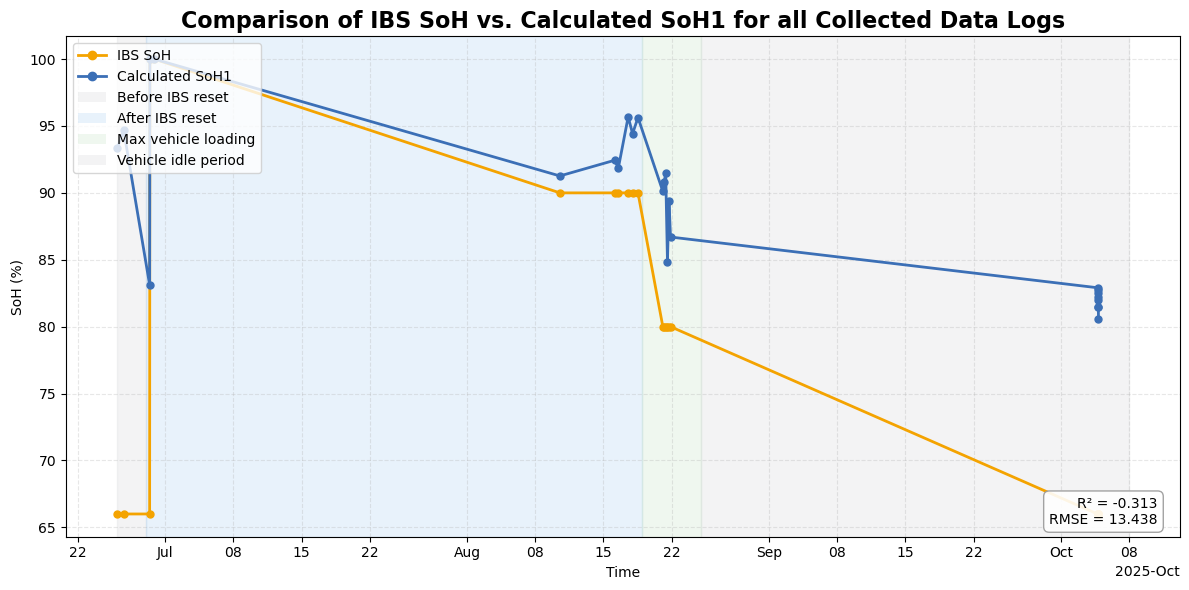

In [43]:
# Run this code to see Figure 5.1 - Comparison of IBS SOH vs calculated SOH1 over all collected data logs

from pathlib import Path
from IPython.display import Image, display

# Define path and resolve
img_path = Path("outputs/figures/manifest_soh_v_soh1_comparison.png")   
resolved_path = img_path.resolve()

# Display Figure 5.1
print("Figure 5.1")
display(Image(filename=resolved_path, width=800))

## 6. Linear Regression cross validation + Ridge + Lasso - SOH & SOH1 
Here we use multi-modal Linear Regression pipeline with cross validation hyperparameters and polynomial features to train models on both targets - IBS SOH and calculated SOH1. The feature data set is our cleaned data logs with IBS only signals that are contained in the project folder /can_data/cleaned/*_IBS_only_cleaned.csv. The notebook cs_lr-gridcv_ibs-only.ipynb contained in the project folder root directory may be loaded by clicking on the link <a href="cs_lr-gridcv_ibs-only" target="_blank">cs_lr-gridcv_ibs-only.ipynb</a> or running the code in the cell below.  

Instead of focusing on the entire time period, we use individual timeseries data logs to train the models due to the steady state behavior of the IBS SOH. Therefore, due to the unbalanced SOH target data we focus on 5 specific logs (out of 25 total) as follows:
- Jun 26 (log id: 2025-06-26_13-39-25): captures the initial battery SOH at a steady state of 66% (**Figure 6.1**)
- Jun 29 (log id: 06-29_08-10-35): there was a slight fluctuation of battery SOH during its only full charge/discharge cycle from 66->64->68% (**Figure 6.2**)
- Jun 29 (log id: 2025-06-29_09-32-11): captures the battery SOH after manual reset of IBS sensor at a steady state of 100% (**Figure 6.3**)
- Aug 10 (log id: 00003): captures the battery SOH 6 weeks after IBS was reset at steady state of 90% (**Figure 6.4**)
- Aug 20 (log id: 2025-08-20_22-17-18_L001): under heavy vehicle loading conditions we manage to capture the battery SOH transitioning from 90% to 80% (**Figure 6.5**)
- Oct 04 (log id: 2025-10-04_13-33-54_L006): captures the final battery SOH 6 weeks after sitting again at final steady state of 66% (original ground truth) (**Figure 6.6**)

In addition, I've included a couple of LR pipeline model training using SOH1 - Figure 6.7 and Figure 6.8. What is observable is how noisy the calculated SOH1 can be for a specific time series. 

In [60]:
# Open linear regress cross validation pipeline notebook by running this cell
import webbrowser
webbrowser.open(Path("cs_lr-gridcv_ibs-only.ipynb").resolve().as_uri())

True

Figure 6.1


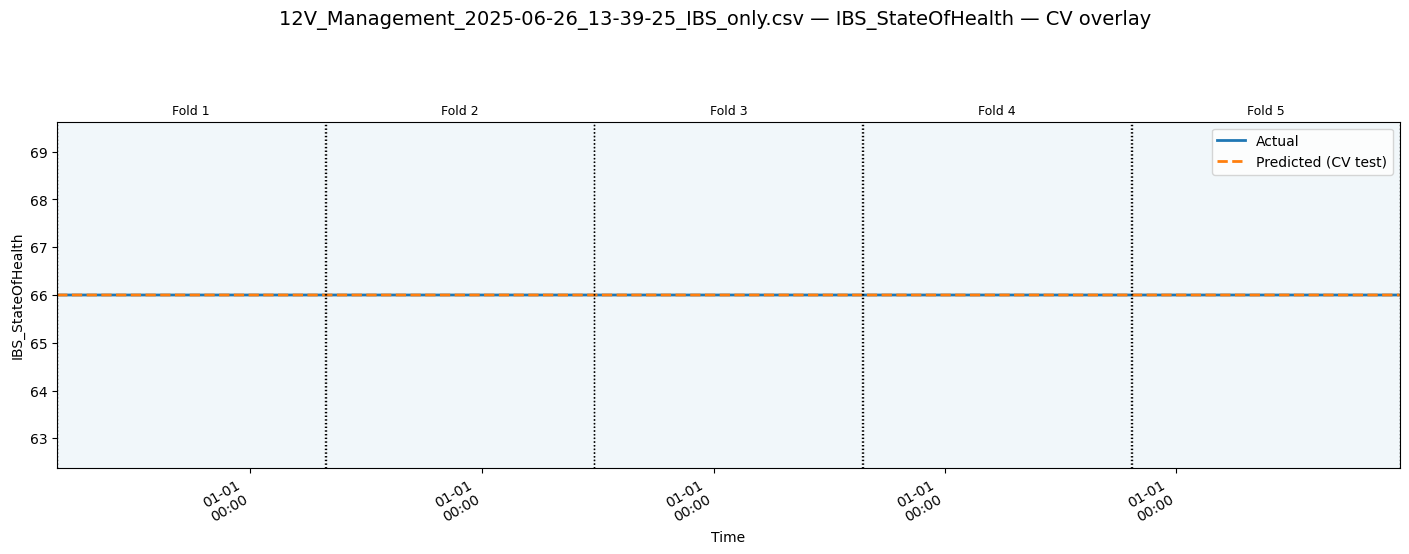

Figure 6.2


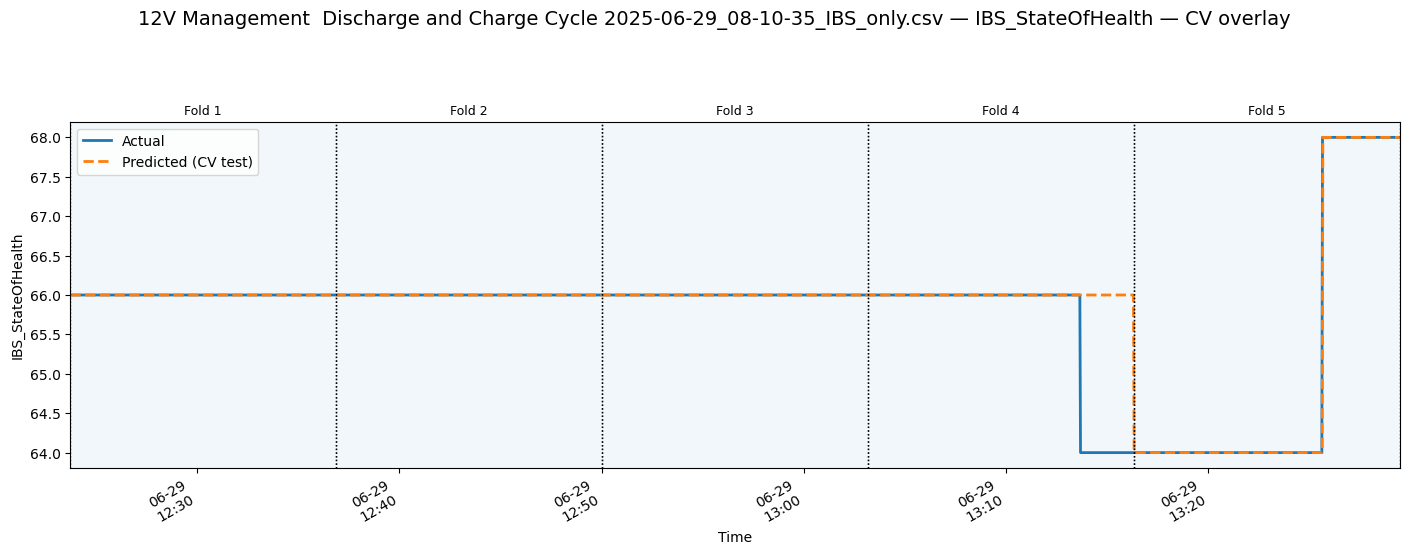

Figure 6.3


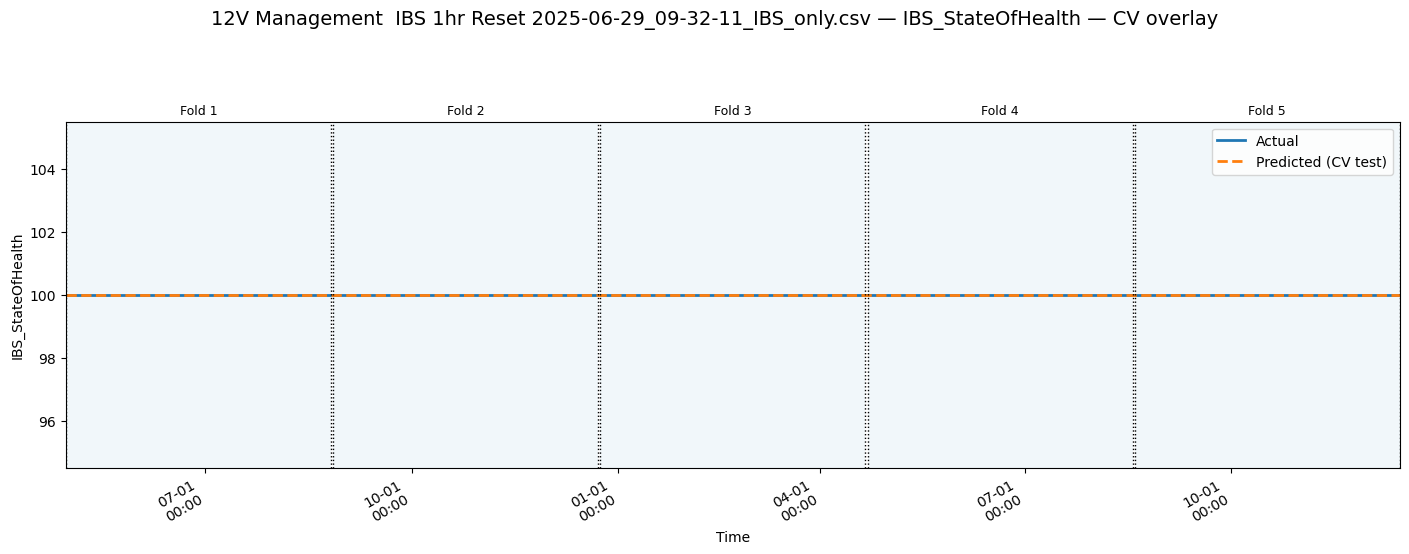

Figure 6.4


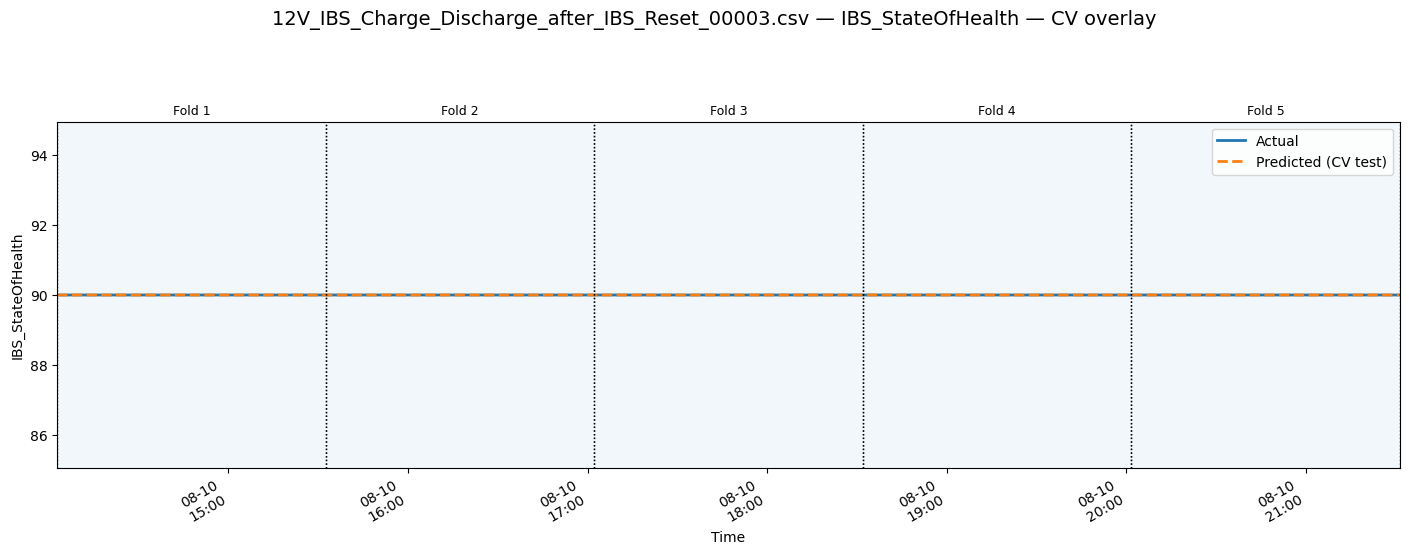

Figure 6.5


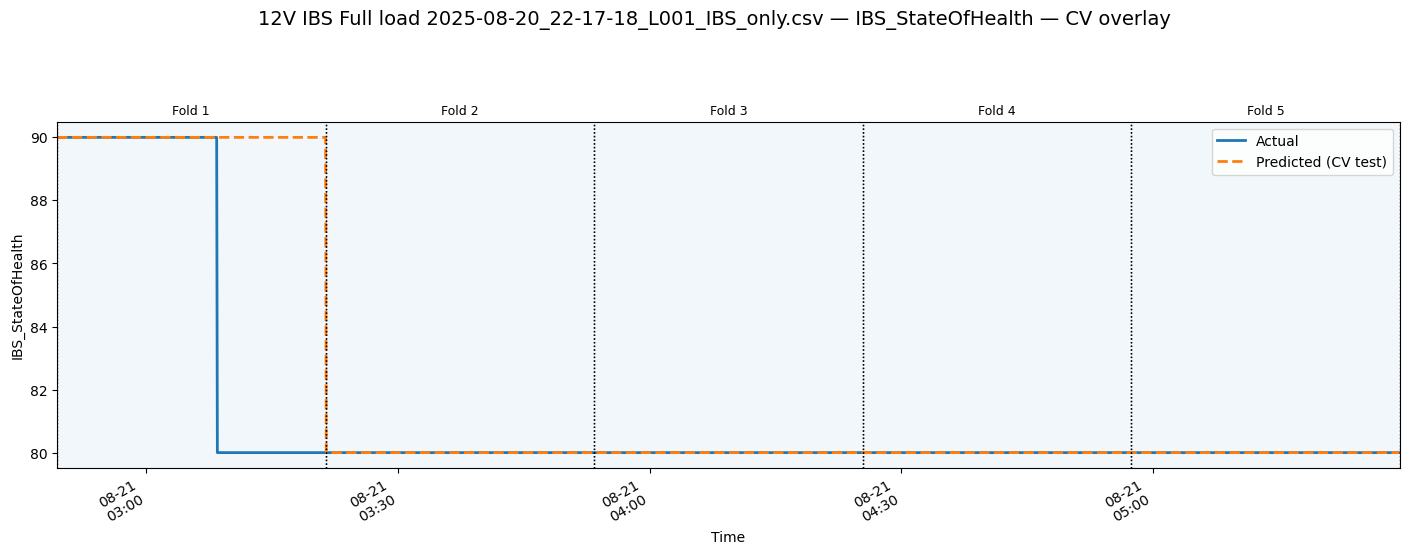

Figure 6.6


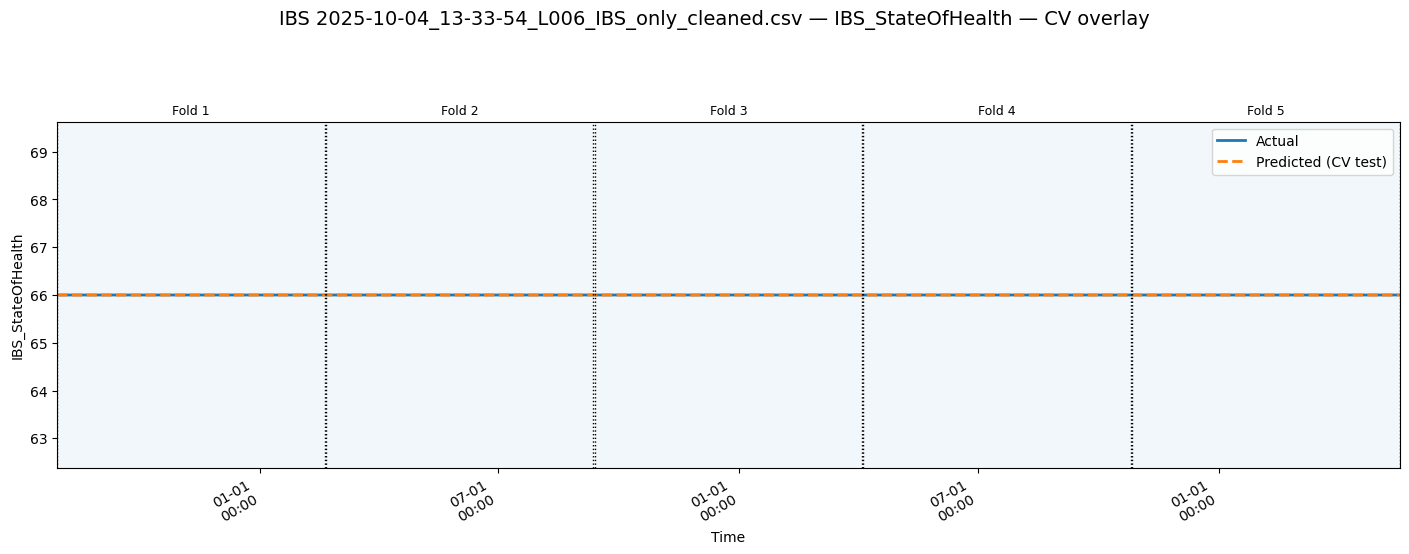

Figure 6.7


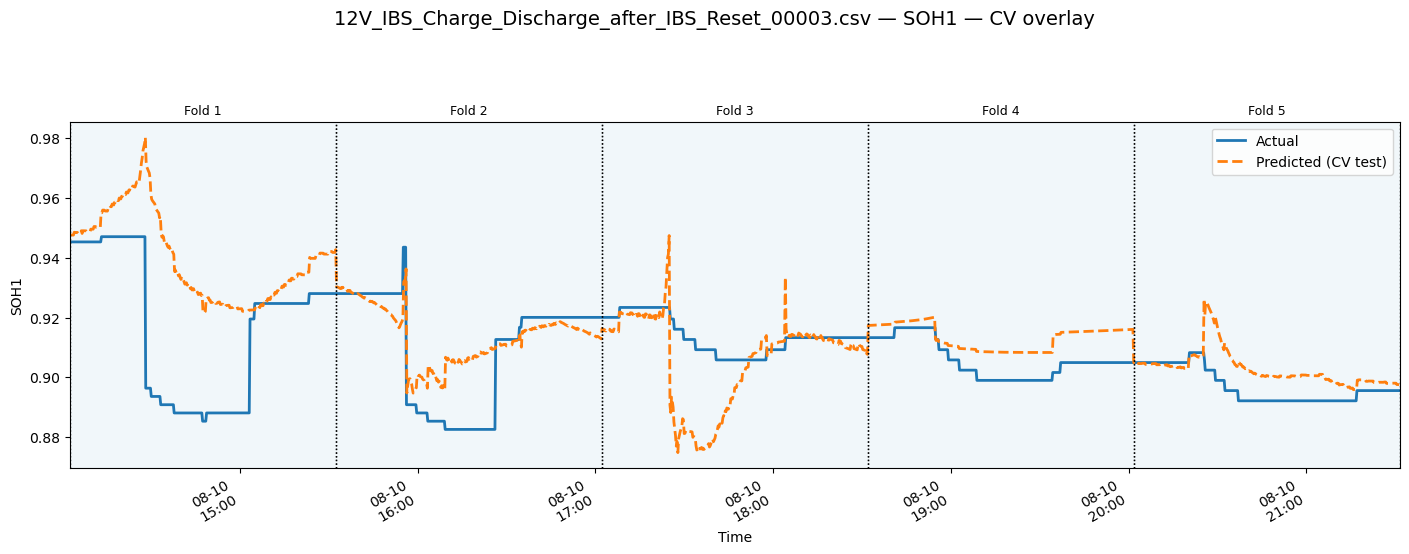

Figure 6.8


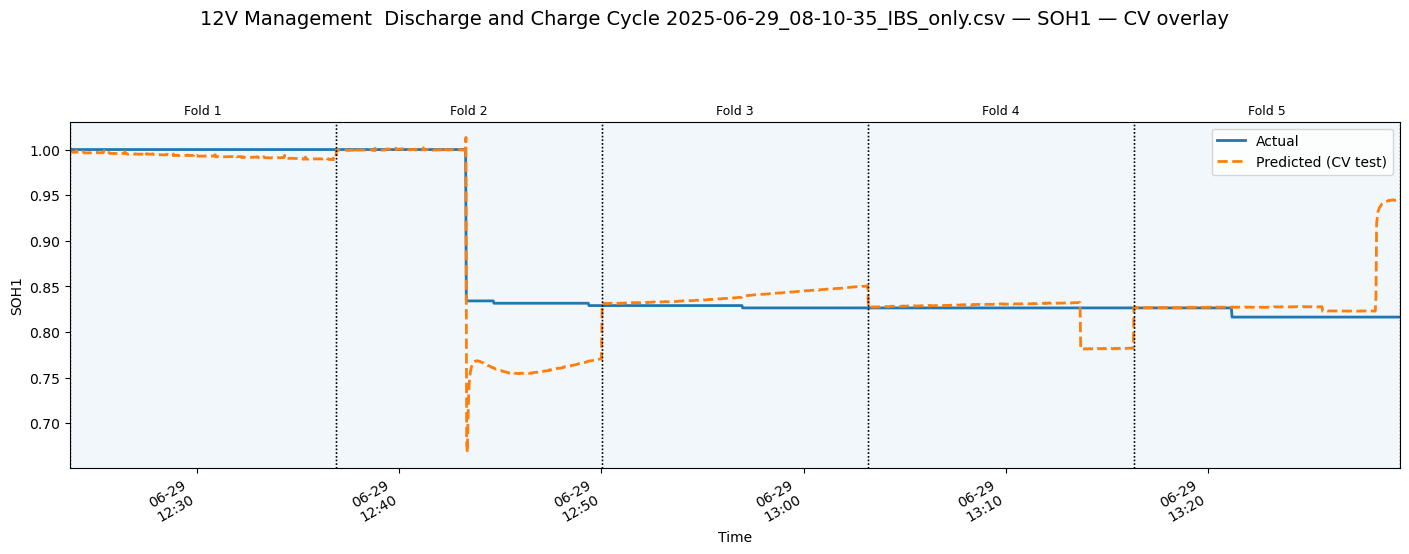

In [46]:
# Run this code to see Figures 6.1 - 6.6 

from pathlib import Path
from IPython.display import Image, display

# Define path and resolve
img_path1 = Path("outputs/figures/LR SOH Overlay 2025-06-26_13-39-25.png")   
resolved_path1 = img_path1.resolve()
img_path2 = Path("outputs/figures/LR SOH Overlay 2025-06-29_08-10-35.png")   
resolved_path2 = img_path2.resolve()
img_path3 = Path("outputs/figures/LR SOH Overlay 2025-06-29_09-32-11.png")   
resolved_path3 = img_path3.resolve()
img_path4 = Path("outputs/figures/LR SOH Overlay 00003.png")   
resolved_path4 = img_path4.resolve()
img_path5 = Path("outputs/figures/LR SOH Overlay 2025-08-20_22-17-18_L001.png")   
resolved_path5 = img_path5.resolve()
img_path6 = Path("outputs/figures/LR SOH Overlay 2025-10-04_13-33-54_L006.png")   
resolved_path6 = img_path6.resolve()
img_path7 = Path("outputs/figures/LR SOH1 Overlay 00003.png")   
resolved_path7 = img_path7.resolve()
img_path8 = Path("outputs/figures/LR SOH1 Overlay 2025-06-29_08-10-35.png")   
resolved_path8 = img_path8.resolve()

# Display Figures 6.1 - 6.6
print("Figure 6.1")
display(Image(filename=resolved_path1, width=800))
print("Figure 6.2")
display(Image(filename=resolved_path2, width=800))
print("Figure 6.3")
display(Image(filename=resolved_path3, width=800))
print("Figure 6.4")
display(Image(filename=resolved_path4, width=800))
print("Figure 6.5")
display(Image(filename=resolved_path5, width=800))
print("Figure 6.6")
display(Image(filename=resolved_path6, width=800))
print("Figure 6.7")
display(Image(filename=resolved_path7, width=800))
print("Figure 6.8")
display(Image(filename=resolved_path8, width=800))

## 7. Expand beyond IBS signals to include charge cycle metrics
Now that we've thoroughly explored IBS only features, let's expand our feature training set to include charge cycle metrics. This comprises features derived from our charging cycles including:
- Voltage response/health
- Charge acceptance/efficiency
- Resistance slope proxies
- Usage/aging context
For each of these parameters we generate the mean, median, std, min, max, p10, p90, first, last. This results in an expanded feature set of 112 features. All derived from the cleaned data logs.
We save these to a new data log outputs/logs/cycle_metrics_all.csv. These metrics will be used next for feature engineering using Random Forest Ensemble modeling. 

The notebook that generates these new features is contained in the root project folder as "cs_gen_charge-cycle-metrics.ipynb" and may be loaded by clicking on the link <a href="cs_gen_charge-cycle-metrics.ipynb" target="_blank">cs_gen_charge-cycle-metrics.ipynb</a> or running the code in the cell below.



In [47]:
# Open generate charge cycle metrics by running this cell
import webbrowser
webbrowser.open(Path("cs_gen_charge-cycle-metrics.ipynb").resolve().as_uri())

True

### 📊 Charging cycle metrics
- Generate consolidated charge cycle metrics -> save to /outputs/logs/cycle_metrics_all.csv. 
- Run the code below to see the generated cycle_metrics_all.csv data file

In [ ]:
import pandas as pd
from pathlib import Path

# Read in charging cycle metrics data file 
OUTPUT_CYCLE_METRICS_CSV = Path("outputs/logs/cycle_metrics_all.csv")
df_cycle = pd.read_csv(OUTPUT_CYCLE_METRICS_CSV)
df_cycle

,cycle_start,cycle_end,source_file,cycle_id,cycle_idx,duration_s,V_peak_charge,V_mean_charge,V_tail_mean,time_absorption_s,...,IBS_Sulfation__last,IBS_BatteryDefect__mean,IBS_BatteryDefect__median,IBS_BatteryDefect__std,IBS_BatteryDefect__min,IBS_BatteryDefect__max,IBS_BatteryDefect__p10,IBS_BatteryDefect__p90,IBS_BatteryDefect__first,IBS_BatteryDefect__last
0,2025-06-26 02:20:47+00:00,2025-06-26 02:40:03+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,0,1156.0,14.115,14.106860,14.100594,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2025-06-26 11:24:45+00:00,2025-06-26 12:02:32+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,1,2267.0,14.114,14.102164,14.099900,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2025-06-26 13:09:11+00:00,2025-06-26 13:19:50+00:00,12V Management 2025-06-25_22-20-47_IBS_only_c...,12V Management 2025-06-25_22-20-47_IBS_only_c...,2,639.0,14.114,14.104331,14.100833,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2025-06-26 17:47:23+00:00,2025-06-26 18:22:49+00:00,12V_Management_2025-06-26_13-39-25_IBS_only.csv,12V_Management_2025-06-26_13-39-25_IBS_only.csv#0,0,2126.0,14.113,14.096117,14.101900,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2025-06-26 22:55:27+00:00,2025-06-26 22:55:42+00:00,12V_Management_2025-06-26_13-39-25_IBS_only.csv,12V_Management_2025-06-26_13-39-25_IBS_only.csv#1,1,15.0,14.062,14.044375,14.044375,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,2025-10-04 18:50:29+00:00,2025-10-04 18:52:46+00:00,IBS 2025-10-04_13-33-54_L010_IBS_only_cleaned.csv,IBS 2025-10-04_13-33-54_L010_IBS_only_cleaned....,0,137.0,14.109,14.096848,14.096848,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,2025-10-04 19:12:33+00:00,2025-10-04 19:16:31+00:00,IBS 2025-10-04_13-33-54_L010_IBS_only_cleaned.csv,IBS 2025-10-04_13-33-54_L010_IBS_only_cleaned....,1,238.0,14.003,13.980397,13.985400,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73,2025-10-04 19:16:31+00:00,2025-10-04 19:33:21+00:00,IBS 2025-10-04_13-33-54_L011_IBS_only_cleaned.csv,IBS 2025-10-04_13-33-54_L011_IBS_only_cleaned....,0,1010.0,14.105,14.072903,14.102161,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
74,2025-10-04 19:33:21+00:00,2025-10-04 19:45:29+00:00,IBS 2025-10-04_13-33-54_L012_IBS_only_cleaned.csv,IBS 2025-10-04_13-33-54_L012_IBS_only_cleaned....,0,728.0,14.109,14.102643,14.095200,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 8. Feature Engineering - Decision Tree & Random Forest 
Let's now explore the subject of Feature Engineering in regards to our expanded IBS signals and charging cycle metrics. We will analyze two approaches — Decision Tree and Random Forrest modeling. We will use the calculated SOH1 as our target since we want to derive features releated to the real-time physics-based behavior of our features. 

### Decision Tree
Decision Tree (DT) modeling is a very simple and straight forward approach that gives us some initial insights without too much of a heavy lift. 
The notebook used to explore DT modeling is given in the notebook contained in the root folder called **cs_dt-grid_cycle-metrics.ipynb**. You can load this notebook by clicking on this link <a href="cs_dt-grid_cycle-metrics.ipynb" target="_blank">cs_dt-grid_cycle-metrics.ipynb</a>  of by running the code in the cell below. 

#### 📊 Analysis
The results very clearly indicate that I_bulk_mean is a highly correlated (~0.6) feature with the calculated SOH1 (**Figure 8.1**). There may be a couple of reasons for this that need to be explored further.
- I_bulk_mean refers to the charging current during a cycle. 
- This can be explained due to higher internal resistance (older batteries heat more under load which makes charging less efficient).
- The charging system may be adapting to the battery health (weaker battery might draw less average current)

In [49]:
# Open DT feature engineering notebook by running this cell
import webbrowser
webbrowser.open(Path("cs_dt-grid_cycle-metrics.ipynb").resolve().as_uri())

True

Figure 8.1


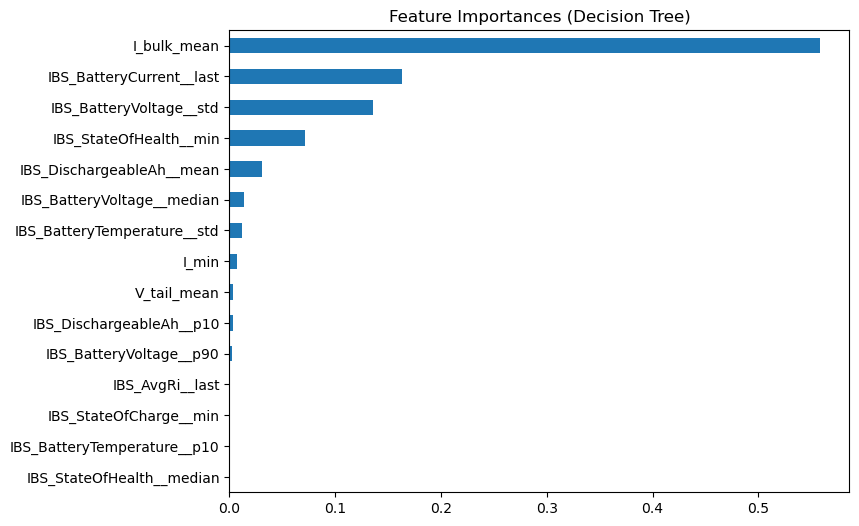

In [ ]:
# Run this cell to see Figure 8.1 
img_path = Path("outputs/figures/DT Feature Importance.png")   
resolved_path = img_path.resolve()

print("Figure 8.1")
display(Image(filename=resolved_path, width=800))

### Random Forest 
Random Forest (RF) Ensemble technique performs a much my thorough analysis of the feature imporance. 
The notebook used to explore the RF modeling is given in the notebook contained in the root project folder called **cs_rf-gridcv_cycle-metrics.ipynb**. You can load this notebook by clicking here <a href="cs_rf-gridcv_cycle-metrics.ipynb" target="_blank">cs_rf-gridcv_cycle-metrics.ipynb</a> or by running the code in the cell below.

#### 📊 Analysis
The results very clearly indicate that IBS_DischarableAh_max is highly correlated (~0.75) with the calculated SOH1 (**Figure 8.2**). Again, we need to explore this further, but some possibilities are given below:
- IBS_DischarableAh_max is an IBS reported estimate of the max Ah that can be safely discharged from the battery under current operating conditions. 
- Physically, it depends on the IBS State of Charge (SoC), State of Function (SoF), and nominal capacity. The basic formula is: 
    DischargeableAh_max = NominalCapacity * f(T, Rint​, SoC)
- So when the battery ages — increasing internal resistance and reducing active plate material — IBS_DischarableAh_max drops proportionally.
- A strong correlation of ~0.6 is evidence that our calculated SOH1 aligns with the IBS's interal capacity mdoel. This validates that our calculated SOH1 algorithm is capturing real underlying battery physics.

In [ ]:
# Open RF feature engineering notebook by running this cell
import webbrowser
webbrowser.open(Path("cs_rf-gridcv_cycle-metrics.ipynb").resolve().as_uri())

Figure 8.2


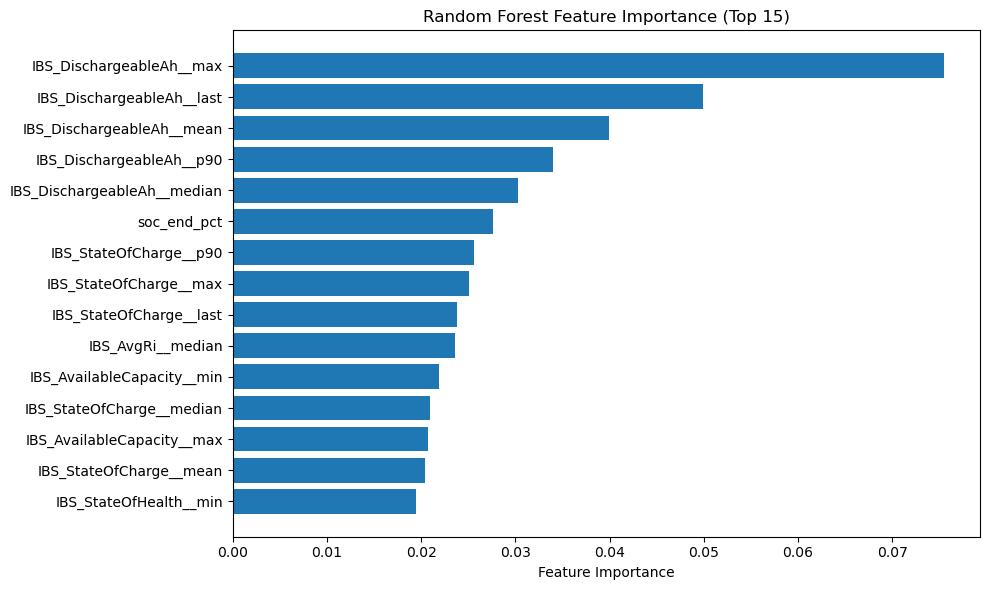

In [52]:
# Run this cell to see Figure 8.2
img_path = Path("outputs/figures/RF Feature Importance.png")   
resolved_path = img_path.resolve()

print("Figure 8.2")
display(Image(filename=resolved_path, width=800))

#### 💡 Final Observations - DT & RF feature engineering
- Both I_bulk_mean and IBS_DischarableAh must be evaluated further. Both show that our underlying physics behind SOH1 are intuitively correct. There is definately room to improve the training with tuning our hyperparameters. This should be explored outside of this project. 

## 9. LSTM approach & data preprocessing
We have already investigated and seen that the IBS reported SOH is a lagging indicator of 12V battery health. To capture real-time dynamics we must move beyond the IBS signals and charging cycle metrics for feature training. Now we will do just that. We will expand our feature set to include all usable network signals. For our data logs this means 2500+ signals. For that we will need to step up to the much more powerful LSTM (Long Short-Term Memory network). LSTMs are a category of RNNs (Recursive Neural Networks) that are can be used for the timeseries data logs collected. They are very good at capturing temporal dependencies and long-range patterns — hence ideal for detecting degradation of the 12V battery under charge/discharge cycles. However, this will require significantly more compute power. 

### Feature Engineering on all signals

The first step is to do some additional feature engineering on our entire set of 2500+ network signals. For this purpose we are using the following notebooks to clean & preprocess our csv data logs. The resulting data sets are contained in the project folder can_data/lstm_preprocessed/*_cleaned_raw.csv. There is a separate notebook for each data log we analyze. We use both IBS SOH and calculated SOH1 as targets to train our LSTMs for purposes explained in the next section. We have also selected the logs that have IBS SOH that exhibits transitional behavior over the logs (ie., SOH is not constant). 
- Data Log Id 0629_08-10-35: <a href="cs_feat_eng_LogID-0629_08-10-35.ipynb" target="_blank">cs_feat_eng_LogID-0629_08-10-35.ipynb</a> (IBS SOH transitions from 66->64->68%)
- Data Log Id 2025-08-20_22-17-18_L001: cs_feat_eng_LogID-0629_08-10-35.ipynb (IBS SOH transitions from 90->80%)

### LSTM preprocessing

The LSTM data log preprocessing steps include:
- Loading in all 2500+ signals from the initial data logs 
- Downsampling to 1 second
- Cleaning column names to include only the signal name
- Removing all duplicate signals
- Dropping all constant signals
- Removing signals that are mostly empty
- Dropping signals that do not contain relevant data including checksums, alivecounters, HV cell data
- Converting all non-numeric signals to numeric (if possible)

The resulting cleaned and preprocessed data logs are stored in the project folder 'can_data/lstm_preprocessed/*_cleaned_scaled.csv'.
Run the second cell below to read in one of the preprocessed data logs considered. 

In [53]:
# Open feature engineering notebook for Log Id 0629_08-10-35 by running this cell
import webbrowser
webbrowser.open(Path("cs_feat_eng_LogID-0629_08-10-35.ipynb").resolve().as_uri())

True

In [55]:
# Run to read in the preprocessed timeseries data log for 2025-06-29_08-10-35
import pandas as pd
from pathlib import Path

OUTPUT_CLEAN_SCALED_CSV = Path("can_data/lstm_preprocessed/12V Management  Discharge and Charge Cycle 2025-06-29_08-10-35_cleaned_raw.csv")
df_final = pd.read_csv(OUTPUT_CLEAN_SCALED_CSV)
df_final

/var/folders/ng/3vcxzr395fd86ffyyn36q09w0000gn/T/ipykernel_82153/1815763749.py:6: DtypeWarning: Columns (391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,456,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,541,542,543,544,545,546,547,548,658) have mixed types. Specify dtype option on import or set low_memory=False.
  df_final = pd.read_csv(OUTPUT_CLEAN_SCALED_CSV)


,time_utc_iso,VCU_214_234_CheckSum,VCU_214_234_AliveCounter,VCU_214_234_CheckSum.1,VCU_214_234_AliveCounter.1,CIM_189_CheckSum,CIM_189_AliveCounter,VCU_100_110_CheckSum,VCU_100_110_AliveCounter,VCU_101_111_CheckSum,...,VCU_LVbattCtrlSigSTGFlt,VCU_93_AliveCounter,VCU_HVBActivateDeactivateRq,VCU_Set_BMS_Mod,IBS_CurrentAutorange,VSP_HornWngSts,VSP_WngMod,VSP_UsrData1_Bit6_DIAGN_AWAKE,WTC_B_HVPwrSplySts,WTC_H_HVPwrSplySts
0,2025-06-29 12:10:35+00:00,176.0,0.0,176.0,0.0,87.0,7.0,208.0,0.0,238.0,...,Normal,NotActive,HV_ON_BatteryShouldbeConnected,BMS_ActiveSet_BMStoActiveMode_WhereitisAWakeAn...,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,inactive,Power_supply,Power_supply
1,2025-06-29 12:10:36+00:00,216.0,10.0,216.0,10.0,98.0,12.0,184.0,10.0,134.0,...,Normal,5,HV_ON_BatteryShouldbeConnected,BMS_ActiveSet_BMStoActiveMode_WhereitisAWakeAn...,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,inactive,Power_supply,Power_supply
2,2025-06-29 12:10:37+00:00,132.0,5.0,132.0,5.0,132.0,1.0,228.0,5.0,218.0,...,Normal,10,HV_ON_BatteryShouldbeConnected,BMS_ActiveSet_BMStoActiveMode_WhereitisAWakeAn...,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,inactive,Power_supply,Power_supply
3,2025-06-29 12:10:38+00:00,176.0,0.0,176.0,0.0,10.0,6.0,208.0,0.0,238.0,...,Normal,NotActive,HV_ON_BatteryShouldbeConnected,BMS_ActiveSet_BMStoActiveMode_WhereitisAWakeAn...,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,inactive,Power_supply,Power_supply
4,2025-06-29 12:10:39+00:00,216.0,10.0,216.0,10.0,236.0,11.0,184.0,10.0,134.0,...,Normal,4,HV_ON_BatteryShouldbeConnected,BMS_ActiveSet_BMStoActiveMode_WhereitisAWakeAn...,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,inactive,Power_supply,Power_supply
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4729,2025-06-29 13:29:24+00:00,11.0,7.0,11.0,7.0,11.0,8.0,226.0,7.0,220.0,...,Normal,11,HV_Off_BatteryShouldbeDisConnected,BMS_SLEEP_SetBMStoSleepMode,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,active,No_power_supply,No_power_supply
4730,2025-06-29 13:29:25+00:00,63.0,2.0,63.0,2.0,63.0,13.0,214.0,2.0,232.0,...,Normal,Active,HV_Off_BatteryShouldbeDisConnected,BMS_SLEEP_SetBMStoSleepMode,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,active,No_power_supply,No_power_supply
4731,2025-06-29 13:29:26+00:00,62.0,12.0,62.0,12.0,99.0,2.0,215.0,12.0,233.0,...,Normal,6,HV_Off_BatteryShouldbeDisConnected,BMS_SLEEP_SetBMStoSleepMode,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,active,No_power_supply,No_power_supply
4732,2025-06-29 13:29:27+00:00,11.0,7.0,11.0,7.0,87.0,7.0,226.0,7.0,220.0,...,Normal,11,HV_Off_BatteryShouldbeDisConnected,BMS_SLEEP_SetBMStoSleepMode,Current_range_I2,Speaker_Not_Working_horn_not_ringing,Not_Work_Inoperative,active,No_power_supply,No_power_supply


## 10. LSTM modeling on all network signals
Now we get to the exciting part - training our LSTM to model 12V battery state of health behavior. First, we use IBS SOH as the supervised learning target to see if we can better model predictions than we had using simpler models such as LR, Lasso, Ridge, and Decision Tree. Secondly, we use the calculated SOH1 as the supervised learning target to see if we can get real-time battery SOH predictions. Both have their purposes. We discuss this further in the Deployment section 10 below. 

Let's first load our LSTM modeling notebooks*. You can do this by clicking here on the notebooks below or running the code in the cells below.
- Data Log Id 0629_08-10-35: <a href="cs_lstm_LogID-0629_08-10-35_v5.ipynb" target="_blank">cs_lstm_LogID-0629_08-10-35_v5.ipynb</a> (IBS SOH transitions from 66->64->68%)
- Data Log Id 2025-08-20_22-17-18_L001: cs_lstm_LogID-2025-08-20_22-17-18_L001.ipynb (IBS SOH transitions from 90->80%)

*Note: due to the compute processing required I have ran the code in these notebooks using the Python (tf-metal) 3.12.2 kernal. This enables the TensorFlow plugin for GPU acceleration on the macOS. Without this the LSTM model training would take hours or days!

#### LSTM - IBS SOH (Log Id: 0629_08-10-35) - **Figure 10.1**

#### LSTM - Calculated SOH1 (Log Id: 0629_08-10-35) - **Figure 10.2**

#### LSTM - Overall LSTM Metrics (Log Id: 0629_08-10-35) - **Figure 10.3**

#### LSTM Model Architecture (Log Id: 0629_08-10-35) - **Figure 10.4**

### 💡 Observations and next steps

- The LSTM model was retrained on the full time series for both IBS-reported and calculated State of Health (SOH) targets, using a 60-second context window and 1-second prediction horizon. Continuous dense inference (stride = 1) produced highly stable, real-time predictions aligned with the original data streams.

- For the calculated SOH1 target, model performance was outstanding — R² = 0.992, RMSE = 0.023, and MAE = 0.011 — indicating that the network successfully learned the temporal evolution of the derived state-of-health metric, capturing both steady-state and transient behavior with exceptional fidelity.

- In contrast, the IBS-reported SOH achieved lower statistical correlation (R² = 0.13), primarily due to its limited dynamic range and stepwise quantization. Nonetheless, visual inspection confirms that predictions remain consistent with actual signal behavior across the timeline.

Overall, these results validate the LSTM pipeline’s ability to model real-world battery health dynamics from vehicle time-series data. The model generalizes well and provides a strong foundation for future embedded or cloud-based inference applications.

Figure 10.1


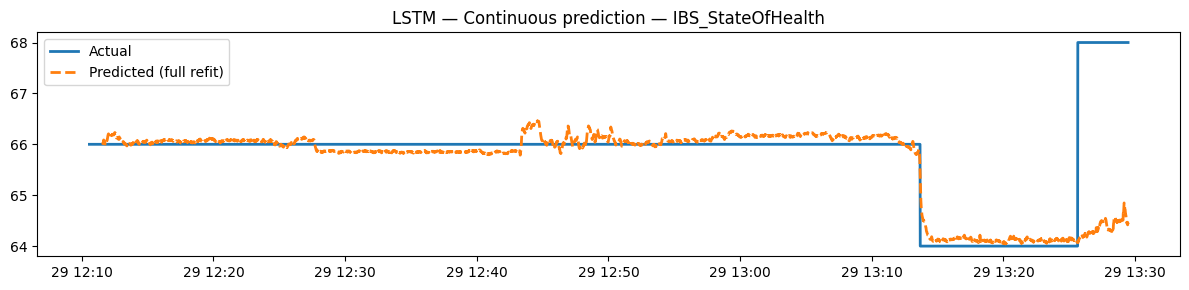

In [61]:
# Run this cell to see the see the LSTM model training set, architecture, predicted output relative to IBS SOH, and error metrics
img_path = Path("outputs/figures/LSTM-SOH LogId-0629_08-10-35_v2.png")   
resolved_path = img_path.resolve()

print("Figure 10.1")
display(Image(filename=resolved_path, width=1000))

Figure 10.2


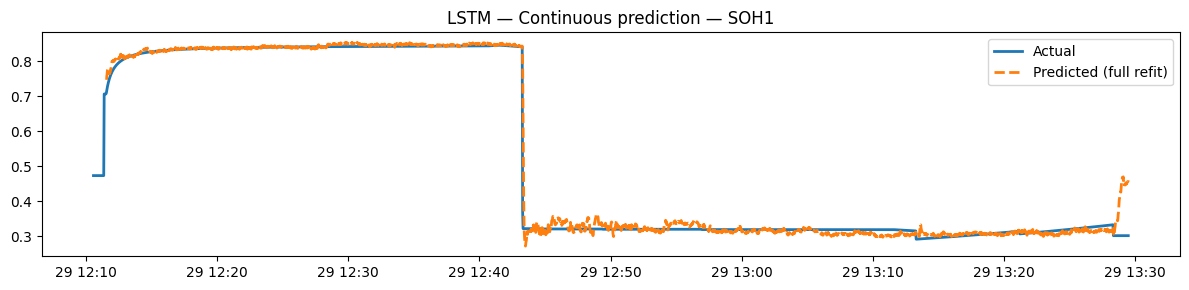

In [62]:
# Run this cell to see the see the LSTM model training set, architecture, predicted output relative to calculated SOH1, and error metrics
img_path = Path("outputs/figures/LSTM-SOH1 LogId-0629_08-10-35_v2.png")   
resolved_path = img_path.resolve()

print("Figure 10.2")
display(Image(filename=resolved_path, width=1000))

Figure 10.2


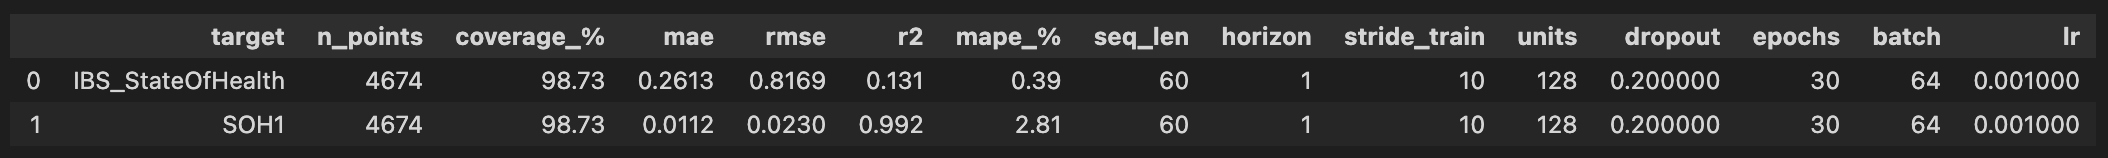

In [ ]:
# Run this cell to see the see the LSTM model error metrics for both continuous prediction plots on both targets - IBS SOH & Calculated SOH1
img_path = Path("outputs/figures/LSTM-Continuous Overall Metrics.png")   
resolved_path = img_path.resolve()

print("Figure 10.3")
display(Image(filename=resolved_path, width=1000))

Figure 10.4


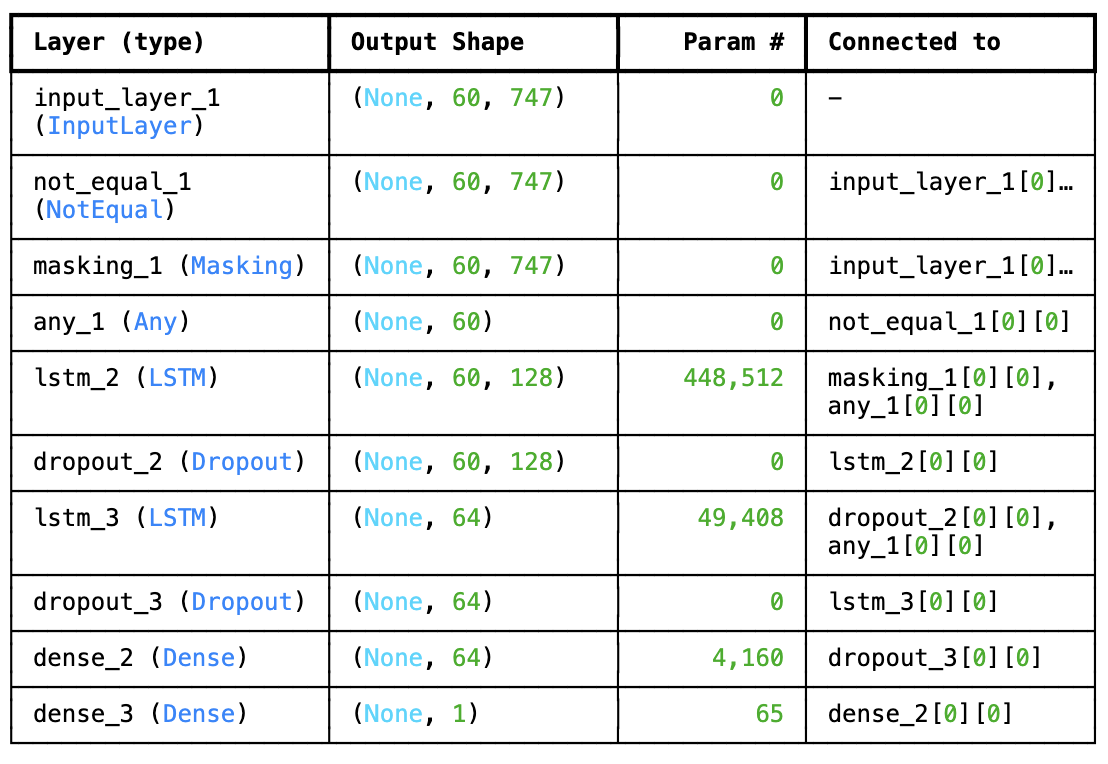

In [66]:
# Run this cell to see the see the LSTM model error metrics for both continuous prediction plots on both targets - IBS SOH & Calculated SOH1
img_path = Path("outputs/figures/LSTM-MODEL LogID-0629_08-10-35.png")   
resolved_path = img_path.resolve()

print("Figure 10.4")
display(Image(filename=resolved_path, width=600))

## 11. Deployment and next steps
These initial results show that once trained, the ML models can run on-vehicle to provide real-time 12V battery SOH estimates from streaming vehicle network data. 

### Embedded SOH Predictor 
- Use of the simpler LR, DT, Ridge, or Lasso models to give additional real-time 12V battery health. 
- May be deployed on-vehicle ECUs as firmware
- For IBS sensor suppliers, this light-weight firmware allows in-vehicle integration of very useful "real-time" predictive diagnostics into existing ECU or telematics platform.

### Cloud SOH Predictor
Use of more robust and powerful LSTM models for:
- OEMs: reduce warranty costs and enhance reliability through "data rich" predictive SOH analytics
- Fleets: enable real-time health dashboards and maintenance scheduling

### 💡 Vision
Vehicle State of Health OS — an AI layer that continuously learns from in-vehicle signals to predict and extend component life, creating self-aware, self-optimizing vehicles.